# SYDE 556/750 --- Assignment 2
**Student ID: 20603167**

*Note:* Please include your numerical student ID only, do *not* include your name.

*Note:* Refer to the [PDF](https://github.com/astoeckel/syde556-w20/raw/master/assignments/assignment_02/syde556_assignment_02.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.

In [1]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import random
import math

# Fix the numpy random seed for reproducible results
np.random.seed(18945)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

# 1. Generating a random input signal

In [2]:
class random_signal: 
      
    # init method or constructor 
    def __init__(self, T, dt, rms, limit, seed, signals, gaus=False): 
        self.T = T              
        self.dt = dt            
        self.rms = rms          
        self.limit = limit
        self.seed = seed 
        self.signals = signals
        self.gaus = gaus
    
    def plot_time(self, ts, xt1, xt2, xt3, 
                  limit, label="Signal", symbol="x"):
         
        fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
        
        # times vs. signal plot
        ax1.plot(ts, xt1, 'r-', label="x with limit = 5 Hz")
        ax1.plot(ts, xt2, 'k--', label="x with limit = 10 Hz")
        ax1.plot(ts, xt3, 'c-', label="x with limit = 20 Hz")
    #         ax1.plot(ts, x_hat, 'k--', label="decoded x")
        ax1.set_xlabel('Time $t$ (s)')
        ax1.set_ylabel('{} ${}$'.format(label, symbol))
        ax1.set_title('Time domain with limit {} Hz'.format(limit)) 
        ax1.set_ylim(-2, 2)
        plt.legend()
        plt.close(fig)
        
        return fig, ax1 
    
    def plot_avgps(self, fw, Xw, label="Signal", symbol="x"): 
        
        # Magic for auto-decting the bandwidth for the magnified plot
        bw = fw[np.max(np.where(np.abs(Xw) > 1e-3))]
        
        fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
        ax1.plot(fw, np.abs(Xw))
        ax1.set_xlabel('$\omega$ in Hz')
        ax1.set_ylabel('Power spectrum $|{}|$'.format(symbol.upper()))
        ax1.set_title('Average Power Spectrum')
#         ax1.set_xlim(-min(20, 2 * bw), min(20, 2 * bw))
        plt.legend()
        plt.close(fig)
    
        return fig, ax1  
        
    def generate_signal(self): 
        ts = np.arange(0, self.T, self.dt) 
        N = ts.size  
        a = np.random.normal(0, 1, int(N/2))
        b = np.random.normal(0, 1, int(N/2)) * 1j
        Xw_p = a + b  
        Xw_n = a - b
        Xw_n = np.flip(Xw_n)
        Xw = np.concatenate((Xw_n, Xw_p), axis=0) 
        fw = np.fft.fftshift(np.fft.fftfreq(N, self.dt))
        
        if len(self.limit) > 1 or self.limit[0] == 30 or (self.limit[0] == 5 and len(self.limit)==1):  
            if self.limit[0] == 30 or (self.limit[0] == 5 and len(self.limit)==1) or (self.limit[0] == 2 and len(self.limit)==1): 
                Xw_ = Xw.copy()
                max_freq = self.limit[0]
                min_freq = -self.limit[0]
                idx = np.where(~np.logical_and(fw>=min_freq, fw<=max_freq))[0] 
                Xw_[idx] = 0
            else:
                Xw_ = np.concatenate(([Xw],[Xw],[Xw]), axis=0) 
                for c,i in enumerate(self.limit):   
                    max_freq = i
                    min_freq = -i  
                    idx = np.where(~np.logical_and(fw>=min_freq, fw<=max_freq))[0] 
                    Xw_[c][idx] = 0 
        else: 
            if (self.gaus):  
                bw = self.limit[0] * 2 * np.pi 
#                 t = np.arange(0, self.T, self.dt * 2) 
                t = np.arange(1, 501, 1)  
                xw = 1/t * (2 * np.pi )
                sig = np.exp(-np.square(xw)/(2*np.square(bw)))  
                a = np.random.normal(0, sig, int(N/2))
                b = np.random.normal(0, sig, int(N/2)) * 1j 
                Xw_p = a + b  
                Xw_n = a - b 
                Xw_n = np.flip(Xw_n)
                Xw_ = np.concatenate((Xw_p,Xw_n), axis=0) 
            else: 
                a = np.random.normal(0, 1, int(N/2))
                b = np.random.normal(0, 1, int(N/2)) * 1j
                Xw_p = a + b  
                Xw_n = a - b 
                Xw_n = np.flip(Xw_n)
                Xw_ = np.concatenate((Xw_p,Xw_n), axis=0)  
                max_freq = self.limit[0]
                min_freq = -self.limit[0]
                idx = np.where(~np.logical_and(fw>=min_freq, fw<=max_freq))[0] 
                Xw_[idx] = 0
            
        if self.signals == 1:   
            if self.limit[0] == 30 or (self.limit[0] == 5 and len(self.limit)==1) or (self.limit[0] == 2 and len(self.limit)==1):  
                x_hat_30 = np.real(np.fft.ifft(np.fft.ifftshift(Xw_))) 
                rms_30 = np.sqrt((1/self.T)*np.sum((x_hat_30**2)*self.dt)) 
                x_hat_30 *= self.rms/rms_30
                Xw_ *= self.rms/rms_30
                fig, ax = plt.subplots(1, 1, figsize=(6, 6)) 
                ax.plot(ts, x_hat_30, 'r-', label="x with limit = 30 Hz")  
                plt.close(fig)
                return fw, Xw_, x_hat_30, fig, ax 
            else: 
                x_hat_5 = np.real(np.fft.ifft(np.fft.ifftshift(Xw_[0])))
                x_hat_10 = np.real(np.fft.ifft(np.fft.ifftshift(Xw_[1])))
                x_hat_20 = np.real(np.fft.ifft(np.fft.ifftshift(Xw_[2])))
                rms_5 = np.sqrt((1/self.T)*np.sum((x_hat_5**2)*self.dt))
                rms_10 = np.sqrt((1/self.T)*np.sum((x_hat_10**2)*self.dt))
                rms_20 = np.sqrt((1/self.T)*np.sum((x_hat_20**2)*self.dt))
                x_hat_5 *= self.rms/rms_5
                x_hat_10 *= self.rms/rms_10
                x_hat_20 *= self.rms/rms_20
                Xw_[0] *= self.rms/rms_5
                Xw_[1] *= self.rms/rms_10
                Xw_[2] *= self.rms/rms_20
                fig, ax = self.plot_time(ts, x_hat_5, x_hat_10, x_hat_20, self.limit)
                plt.close(fig)
        else: 
            x_hat = np.real(np.fft.ifft(np.fft.ifftshift(Xw_)))
            rms = np.sqrt((1/self.T)*np.sum((x_hat**2)*self.dt))
#             rms = np.sqrt((1/self.T)*np.sum((x_hat**2)))
            x_hat *= self.rms/rms 
            Xw_ *= self.rms/rms 
            return fw, Xw_, x_hat
              
        return fw, Xw_, x_hat_5, x_hat_10, x_hat_20, fig, ax   


## 1.1 Band-limited white noise

**a) Time-domain signals.** Plot $x(t)$ for three randomly generated signals with \textt{limit} at $5$, $10$, and $20\,\mathrm{Hz}$. For each of these, $\mathtt{T}=1\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$ and $\mathtt{rms}=0.5$.

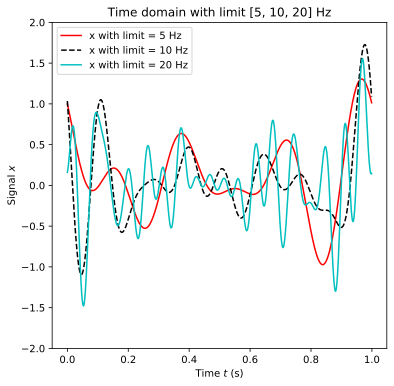

In [3]:
# ✍ 
# limits in Hz
limit = [5, 10, 20]    
_ = random_signal(T=1, dt=1e-3, rms=0.5, limit=limit, 
                      seed=random.seed(18945), signals=1)
q,w,e,r,t,f, __ = _.generate_signal() 
display(f) 

**b) Average power spectrum.** Plot the average $|X(\omega)|$ (the norm of the Fourier coefficients, or “power spectrum”) over $100$ signals generated with $\mathtt{T}=1\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$, $\mathtt{rms}=0.5$, and $\mathtt{limit}=0.5$ (of course, each of these 100 signals should have a different `seed`). The plot should have the $x$-axis labeled “$\omega$ in radians” and the average $|X|$ value for that $\omega$ on the $y$-axis.

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
No handles with labels found to put in legend.


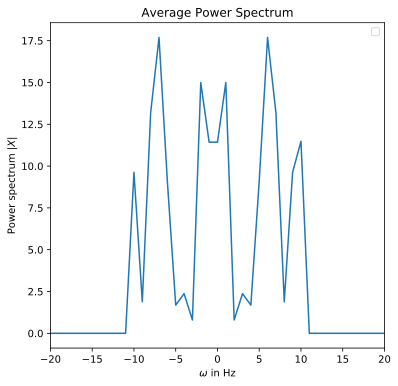

In [4]:
# ✍   
signals=100 
fw = np.zeros((signals,1000))
Xw_ = np.zeros((signals,1000))
x_hat = np.zeros((signals,1000))

for i in range(signals): 
    _ = random_signal(T=1, dt=1e-3, rms=0.5, limit=[10], 
                  seed=np.random.seed(), signals=100) 
    fw[i], Xw_[i], x_hat[i] = _.generate_signal()

Xw_a = np.mean(Xw_, axis=0)
fw_a = np.mean(fw, axis=0)

fig, ax = _.plot_avgps(fw_a, np.abs(Xw_a), label="Signal", symbol="x")
bw = fw_a[np.max(np.where(np.abs(Xw_a) > 1e-3))]
ax.set_xlim(-min(20, 2 * bw), min(20, 2 * bw))
display(fig)

## 1.2 Gaussian power spectrum noise

**a) Time-domain signals.** Plot $x(t)$ for three randomly generated signals with `bandwidth` at $5$, $10$, and $20\,\mathrm{Hz}$. For each of these, $\mathtt{T}=1\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$ and $\mathtt{rms}=0.5$.

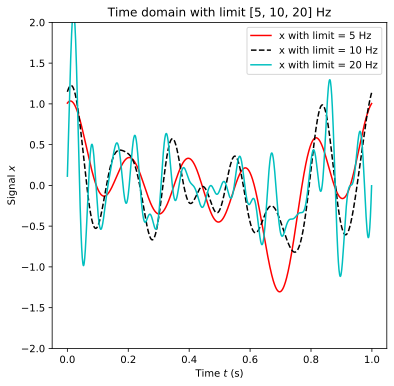

In [5]:
# ✍ 
# limits in Hz
bandwidth = [5, 10, 20]    
_ = random_signal(T=1, dt=1e-3, rms=0.5, limit=bandwidth, 
                      seed=random.seed(18945), signals=1, gaus=True)
q,w,e,r,t,f,__ = _.generate_signal() 
display(f)

**b) Average power spectrum.** Plot the average $|X(\omega)|$ (the norm of the Fourier coefficients, or “power spectrum”) over $100$ signals generated with $\mathtt{T}=1\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$, $\mathtt{rms}=0.5$, and $\mathtt{bandwidth}=10$ (of course, each of these 100 signals should have a different `seed`). The plot should have the $x$-axis labeled “$\omega$ in radians” and the average $|X|$ value for that $\omega$ on the $y$-axis.

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
No handles with labels found to put in legend.


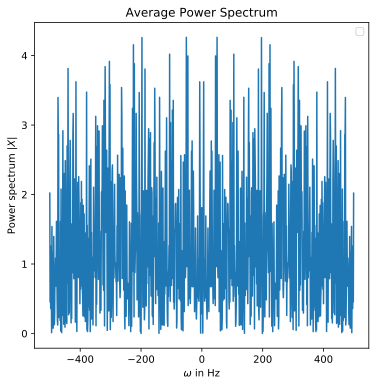

In [6]:
# ✍   
signals=100 
fw = np.zeros((signals,1000))
Xw_ = np.zeros((signals,1000))
x_hat = np.zeros((signals,1000))

for i in range(signals): 
    _ = random_signal(T=1, dt=1e-3, rms=0.5, limit=[10], 
                  seed=np.random.seed(), signals=100, gaus=True) 
    fw[i], Xw_[i], x_hat[i] = _.generate_signal()

Xw_a = np.mean(Xw_, axis=0)
fw_a = np.mean(fw, axis=0)

fig, ax1 = _.plot_avgps(fw_a, Xw_a, label="Signal", symbol="x")
# bw = fw_a[np.max(np.where(np.abs(Xw_a) > 1e-3))]
# ax1.set_xlim(-min(20, 2 * bw), min(20, 2 * bw))
display(fig)

# 2. Simulating a spiking neuron

**a) Spike plots for constant inputs.** Plot the spike output for a constant input of $x=0$ over $1$ second. Report the number of spikes. Do the same thing for $x=1$. Use a time step of $\Delta t = 1\,\mathrm{ms}$ for the simulation.

In [7]:
def spike_neurons(xt, e, T):
    dt = 1e-3
    ts = np.linspace(0, T, int(T/dt))
    Tref = 2e-3
    Trc = 20e-3
    a_0 = 40 
    a_1 = 150 

    j_bias = np.divide(1,1 - math.exp(np.divide(((a_0*Tref)-1),(a_0*Trc)))) - (0)  
    alpha = np.divide(1,1 - math.exp(np.divide(((a_1*Tref)-1),(a_1*Trc)))) - j_bias

    J = np.multiply(e*alpha, xt) + j_bias

    v, τ = 0.0, 0.0
    vs = np.zeros_like(ts) 
    for i, t in enumerate(ts): 
        if τ > 0.0:
            v = 0.0
            τ -= dt
        else:
            v = v + dt * (J[i] - v) / Trc 
            if v > 1.0:
                v = 5.0
                τ = Trc
        vs[i] = v
        
    return ts, vs 

23


Text(0.5, 1.0, 'Spike Output for x=0')

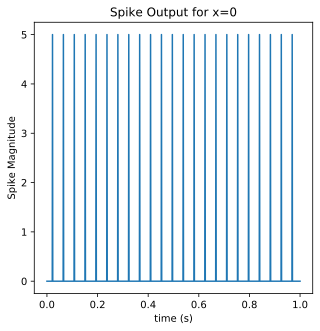

In [8]:
T = 1
dt = 1e-3 

xt = [0]*int(T/dt)  
ts, v_0 = spike_neurons(xt,1, 1)

fig, ax1 = plt.subplots(1, 1, figsize=(5, 5)) 

spike = v_0.copy() 
spike[np.where(~np.logical_or(spike==0, spike==5))]=0 

print(len(np.where(spike>0)[0]))

ax1.plot(ts, spike)
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Spike Magnitude')
ax1.set_title('Spike Output for x=0')

40


Text(0.5, 1.0, 'Spike Output for x=1')

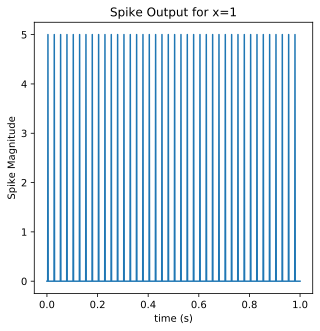

In [9]:
T = 1
dt = 1e-3 

xt = [1]*int(T/dt)  
ts, v_1 = spike_neurons(xt,1,1)

fig, ax1 = plt.subplots(1, 1, figsize=(5, 5)) 

spike = v_1.copy() 
spike[np.where(~np.logical_or(spike==0, spike==5))]=0 

print(len(np.where(spike>0)[0]))

ax1.plot(ts, spike)
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Spike Magnitude')
ax1.set_title('Spike Output for x=1')

**b) Discussion.** Does the observed number of spikes in the previous part match the expected number of spikes for $x=0$ and $x=1$? Why or why not? What aspects of the simulation would affect this accuracy?

✍ As x is increased from 0 to 1, the voltage differential has a larger difference in each calcuation. Being that the equation comes from the LIF model, having x as a constant (and not dependent on t) means the model isn't as accurate as it would be with x being dependent on time.    

**c) Spike plots for white noise inputs.** Plot the spike output for $x(t)$ generated using your function from part 1.1. Use $\mathtt{T}=1\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$, $\mathtt{rms}=0.5$, and $\mathtt{limit}=30\,\mathrm{Hz}$. Overlay on this plot $x(t)$.

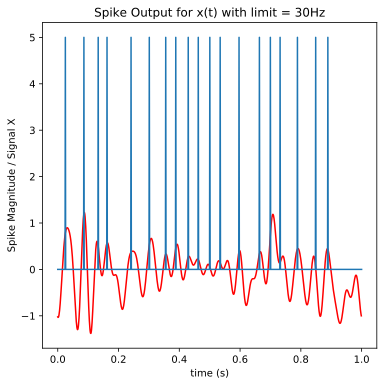

In [10]:
# ✍ 
limit = [30]    
_ = random_signal(T=1, dt=1e-3, rms=0.5, limit=limit, 
                      seed=random.seed(18945), signals=1)
fw, X, x, f, a = _.generate_signal() 

ts, v_x = spike_neurons(x,1,1)

spike = v_x.copy() 
spike[np.where(~np.logical_or(spike==0, spike==5))]=0 
 
a.plot(ts, spike) 
a.set_xlabel("time (s)")
a.set_ylabel("Spike Magnitude / Signal X")
a.set_title("Spike Output for x(t) with limit = 30Hz")
display(f)

**d) Voltage over time.** Using the same $x(t)$ signal as in part *c)*, plot the neuron's voltage over time for the first $0.2$ seconds, along with the spikes over the same time.

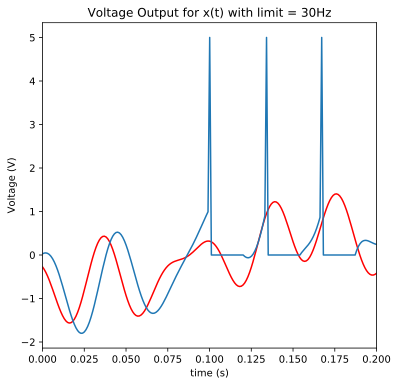

In [11]:
# ✍
limit = [30]    
_ = random_signal(T=1, dt=1e-3, rms=0.5, limit=limit, 
                      seed=random.seed(18945), signals=1)
fw, X, x, f, a = _.generate_signal() 

ts, v_x = spike_neurons(x,1,1)
 
a.plot(ts, v_x) 
a.set_xlim(0, 0.2)
a.set_xlabel("time (s)")
a.set_ylabel("Voltage (V)")
a.set_title("Voltage Output for x(t) with limit = 30Hz")
display(f)

**e) 🌟 Bonus question.** How could you improve this simulation (in terms of how closely the model matches actual equation) without significantly increasing the computation time? $0.5$ marks for having a good idea. Up to $1$ mark for actually implementing it and showing that it works.

✍ \<YOUR SOLUTION HERE\>

In [12]:
# ✍ <YOUR SOLUTION HERE>

# 3. Simulating two spiking neurons

**a) Spike plots for constant inputs.** Plot $x(t)$ and the spiking output for $x(t)=0$ (both neurons should spike at about $40$ spikes per second), as well as (in a separate plot) $x(t)=1$ (one neuron should spike at $\approx 150$ spikes per second, and the other should not spike at all).

23
23


Text(0.5, 1, 'Spike Output for 2 neurons, x = 0')

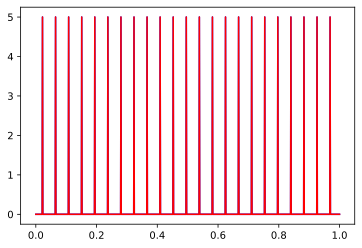

In [13]:
# ✍ 
xt = [0]*int(T/dt)
ts, v_x_p = spike_neurons(xt,1,1)
ts, v_x_n = spike_neurons(xt,-1,1)

fig, ax = plt.subplots(1, 1, figsize=(6, 4)) 

spike_p = v_x_p.copy() 
spike_p[np.where(~np.logical_or(spike_p==0, spike_p==5))]=0 

spike_n = v_x_n.copy() 
spike_n[np.where(~np.logical_or(spike_n==0, spike_n==5))]=0 

# ax.plot(ts, v_x_n)
ax.plot(ts, spike_p, '-b') 
ax.plot(ts, spike_n, '-r') 
print(len(np.where(spike_p==5)[0]))
print(len(np.where(spike_n==5)[0]))
a.set_xlabel("time (s)")
a.set_ylabel("Spike Magnitude")
a.set_title("Spike Output for 2 neurons, x = 0")
# display(fig)

40
0


Text(0.5, 1.0, 'Spike Output for 2 neurons, x = 1')

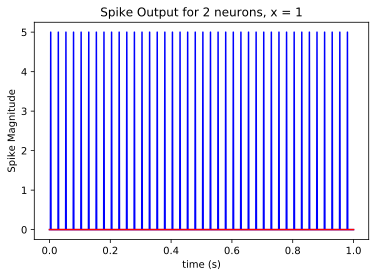

In [14]:
# ✍ 
xt = [1]*int(T/dt)
ts, v_x_p = spike_neurons(xt,1,1)
ts, v_x_n = spike_neurons(xt,-1,1)

fig, ax = plt.subplots(1, 1, figsize=(6, 4)) 

spike_p = v_x_p.copy() 
spike_p[np.where(~np.logical_or(spike_p==0, spike_p==5))]=0 

spike_n = v_x_n.copy() 
spike_n[np.where(~np.logical_or(spike_n==0, spike_n==5))]=0 

# ax.plot(ts, v_x_n)
ax.plot(ts, spike_p, '-b') 
ax.plot(ts, spike_n, '-r') 
print(len(np.where(spike_p==5)[0]))
print(len(np.where(spike_n==5)[0]))
ax.set_xlabel("time (s)")
ax.set_ylabel("Spike Magnitude")
ax.set_title("Spike Output for 2 neurons, x = 1")
# display(fig)

**b) Spike plots for a sinusodial input.** Plot $x(t)$ and the spiking output for $x(t)=\frac{1}2 \sin(10 \pi t)$.

Text(0.5, 1.0, 'Spike Output for 2 neurons, sinusoidal input')

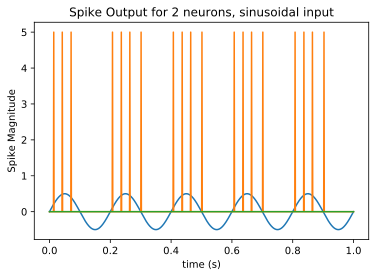

In [15]:
# ✍ 
x_t = .5 * np.sin(10 * np.pi * ts)
fig, ax = plt.subplots(1, 1, figsize=(6, 4)) 

ts, v = spike_neurons(x_t,1,1)
ts, v_n = spike_neurons(xt,-1,1)

spike_p = v.copy() 
spike_n = v_n.copy() 

spike_p[np.where(~np.logical_or(spike_p==0, spike_p==5))]=0 
spike_n[np.where(~np.logical_or(spike_n==0, spike_n==5))]=0 
ax.plot(ts, x_t)
ax.plot(ts, spike_p)
ax.plot(ts, spike_n)
ax.set_xlabel("time (s)")
ax.set_ylabel("Spike Magnitude")
ax.set_title("Spike Output for 2 neurons, sinusoidal input")
# display(fig)

**c) Spike plot for a white noise signal.** Plot $x(t)$ and the spiking output for a random signal generated with your function for question 1.1 with $\mathtt{T}=2\,\mathrm{s}$, $\mathtt{dt}=0.5\,\mathrm{s}$, $\mathtt{rms}=0.5$, and $\mathtt{limit}=5\,\mathrm{Hz}$.

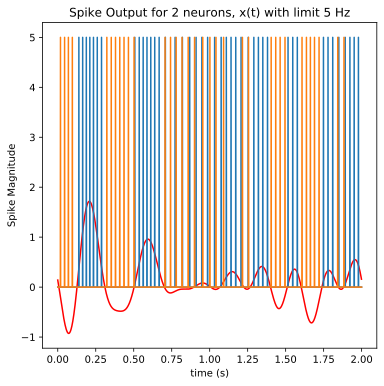

In [16]:
# ✍ 
limit = [5]    
_ = random_signal(T=2, dt=1e-3, rms=0.5, limit=limit, 
                      seed=random.seed(18945), signals=1)
fw, X, x, f, a = _.generate_signal() 

ts, v_x_p = spike_neurons(x,1,2)
ts, v_x_n = spike_neurons(x,-1,2)

spike_p = v_x_n.copy() 
spike_p[np.where(~np.logical_or(spike_p==0, spike_p==5))]=0
spike_n = v_x_p.copy() 
spike_n[np.where(~np.logical_or(spike_n==0, spike_n==5))]=0
 
a.plot(ts, spike_n) 
a.plot(ts, spike_p) 
a.set_xlabel("time (s)")
a.set_ylabel("Spike Magnitude")
a.set_title("Spike Output for 2 neurons, x(t) with limit 5 Hz")

display(f)

# 4. Computing an optimal filter

**a) Document the code.** Fill in comments where there are `# !`-signs in the Python code. Make sure that your comments (where this makes sense) describe the semantics of the code and do not just repeat what is obvious from the code itself. Run the function with what you wrote for part 3 above, so that it uses the spike signal generated in 3c).

In [17]:
def compute_optimal_filter(
        # Signal generated from your white noise generator
        x,
        # Fourier coefficients from your white noise generator
        X,
        # Spike train from the previous part
        spikes,
        # Time step size
        dt=1e-3
    ):

    # x and X should (effectively) be 1D-arrays
    assert x.ndim == 1 and X.ndim == 1
    assert x.shape[0] == X.shape[0]

    # ! storing the amount of discrete samples in our signal 
    Nt = x.size

    # Make sure that "spikes" is a 2 x Nt array
    assert spikes.ndim == 2
    assert spikes.shape[0] == 2              
    assert spikes.shape[1] == Nt

    # ! storing duration of signal  
    T = Nt * dt

    # ! creating a an array in the range of 0 to # of signals, multiplying increment so that values are from 0-T, 
    # subtracting T (duation of signals) from all the values so that the array shifts to  
    # -T to 0, and dividing by 2 to get half the number of time values from the -T to zero 
    ts = np.arange(Nt) * dt - T / 2.0

    # ! converting time signal to Hz but double the signal, so entire set of Hz values are captured 
    fs = np.arange(Nt) / T - Nt / (2.0 * T)

    # ! converting Hz to radians
    omega = fs * 2.0 * np.pi

    # ! subtracting first activation from second, due to symmetry  
    r = spikes[0] - spikes[1]

    # ! fouriering transforming and centering the new r (a)
    R = np.fft.fftshift(np.fft.fft(r))

    # ! setting a small standard deviation (to increase filter magnitude in time domain)
    sigma_t = 25e-3

    # ! computing exponential term of filter 
    W2 = np.exp(-omega**2*sigma_t**2)

    # ! computing integral of filter term
    W2 = W2 / sum(W2)

    # ! multiply frequency signal with activation term to get numerator of first optimal filter iteration 
    CP = X*R.conjugate()

    # ! multiply CP by previous filtered term to get numerator of improved filter term
    WCP = np.convolve(CP, W2, 'same')

    # ! squaring R of the symmetric activations to get |R|^2 
    RP = R*R.conjugate()

    # ! Convolving symmetric activation term with filter to get improved filter denominator 
    WRP = np.convolve(RP, W2, 'same')

    # !
    XP = X*X.conjugate()

    # !
    WXP = np.convolve(XP, W2, 'same')

    # ! computing the improved filter  
    H = WCP / WRP

    # ! decoding the filter into the time domain 
    h = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(H))).real

    # ! multiply the filter with the activation (can be multiplication in the frequency domain) 
    # to compute deocded x-values (d was truncated into h)
    XHAT = H*R

    # ! convert decoded x terms into time domain and shift them to about 0, throw away residual imaginary values 
    xhat = np.fft.ifft(np.fft.ifftshift(XHAT)).real

    return ts, fs, R, H, h, XHAT, xhat

**b) Optimal filter.** Plot the time and frequency plots of the optimal filter for the signal you generated in question 3c). Make sure to use appropriate limits for the $x$-axis.

/anaconda/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Power Spectrum |X|')

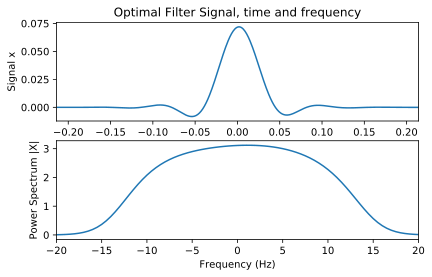

In [18]:
# ✍ 
limit = [5]    
_ = random_signal(T=2, dt=1e-3, rms=0.5, limit=limit, 
                      seed=random.seed(18945), signals=1)
fw, X, x, f, a = _.generate_signal() 

ts, v_x_p = spike_neurons(x,1,2)
ts, v_x_n = spike_neurons(x,-1,2)

spike_p = v_x_n.copy() 
spike_p[np.where(~np.logical_or(spike_p==0, spike_p==5))]=0
spike_n = v_x_p.copy() 
spike_n[np.where(~np.logical_or(spike_n==0, spike_n==5))]=0

spk = np.concatenate((spike_n, spike_p), axis=0).reshape(2, len(spike_n))

ts_h, fs, R, H, h, XHAT, xhat = compute_optimal_filter(x, X, spk)

figure, (a1, a2) = plt.subplots(2, 1, figsize=(6.5, 4)) 
a1.plot(ts_h, h)
a2.plot(fs, H)
b1 = ts_h[np.max(np.where(np.abs(h) > 1e-3))]
b2 = fs[np.max(np.where(np.abs(H) > 1e-3))]
a1.set_xlim(-min(20, 2 * b1), min(20, 2 * b1))
a2.set_xlim(-min(20, 2 * b2), min(20, 2 * b2))
a1.set_xlabel("time (s)")
a1.set_ylabel("Signal x")
a1.set_title("Optimal Filter Signal, time and frequency")
a2.set_xlabel("Frequency (Hz)")
a2.set_ylabel("Power Spectrum |X|") 

**c) Decoded signal.** Plot the $x(t)$ signal, the spikes, and the decoded $\hat x(t)$ value for the signal from 3c).

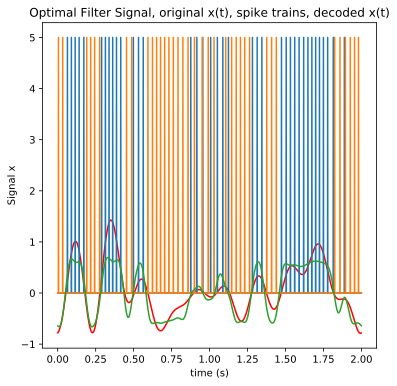

In [19]:
# ✍ <YOUR SOLUTION HERE>
a.plot(ts, spike_n) 
a.plot(ts, spike_p)
a.plot(ts, xhat)
a.set_xlabel("time (s)")
a.set_ylabel("Signal x")
a.set_title("Optimal Filter Signal, original x(t), spike trains, decoded x(t)")
display(f)

**d) Power spectra.** Plot the signal $|X(\omega)|$, spike response $|R(\omega)|$, and filtered signal $|\hat X(\omega)|$ power spectra for the signal from 3c).

Text(0.5, 1.0, 'Optimal Filter Power Spectra')

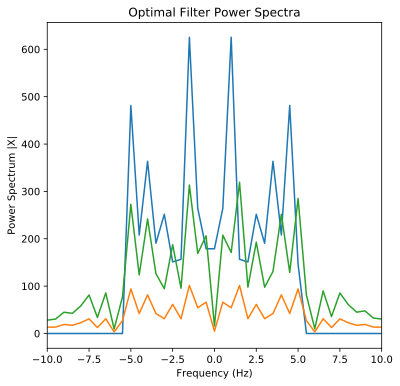

In [20]:
# ✍ <YOUR SOLUTION HERE>
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(fs,np.abs(X))
ax.plot(fs,np.abs(R))
ax.plot(fs,np.abs(XHAT))
bs = fs[np.max(np.where(np.abs(X) > 1e-3))]
ax.set_xlim(-min(20, 2 * bs), min(20, 2 * bs))
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power Spectrum |X|")
ax.set_title("Optimal Filter Power Spectra")
# ax.plot(fs, )

**e) Discussion.** How do these spectra relate to the optimal filter?

✍ The spectra of the that has been filtered has a lower magnitude. Multiplying the X by R, which has a lower magnitude than X, causes this. 

**f) Filter for different signal bandwidths.** Plot the optmial filter $h(t)$ in the time domain when filtering spike trains for white noise signals with different `limit` values of $2\,\mathrm{Hz}$, $10\,\mathrm{Hz}$, and $30\,\mathrm{Hz}$.

Text(0.5, 1.0, 'Optimal Filter for 5Hz, 10 Hz, 20 Hz')

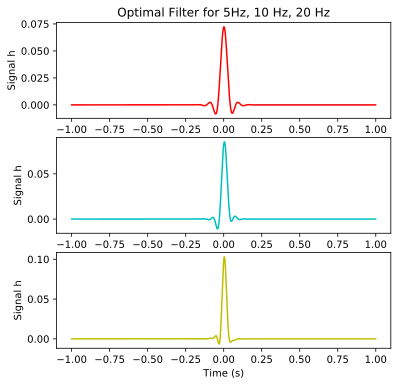

In [21]:
# ✍ <YOUR SOLUTION HERE>
bandwidth = [5, 10, 20]    
_ = random_signal(T=2, dt=1e-3, rms=0.5, limit=bandwidth, 
                      seed=random.seed(18945), signals=1, gaus=True)
q,w,e,r,y,f,__ = _.generate_signal() 

ts, v_5_p = spike_neurons(e,1,2)
ts, v_5_n = spike_neurons(e,-1,2)
ts, v_10_p = spike_neurons(r,1,2)
ts, v_10_n = spike_neurons(r,-1,2)
ts, v_20_p = spike_neurons(y,1,2)
ts, v_20_n = spike_neurons(y,-1,2)

spike_5_p = v_5_p.copy() 
spike_5_p[np.where(~np.logical_or(spike_5_p==0, spike_5_p==5))]=0
spike_5_n = v_5_n.copy() 
spike_5_n[np.where(~np.logical_or(spike_5_n==0, spike_5_n==5))]=0

spike_10_p = v_10_p.copy() 
spike_10_p[np.where(~np.logical_or(spike_10_p==0, spike_10_p==5))]=0
spike_10_n = v_10_n.copy() 
spike_10_n[np.where(~np.logical_or(spike_10_n==0, spike_10_n==5))]=0

spike_20_p = v_20_p.copy() 
spike_20_p[np.where(~np.logical_or(spike_20_p==0, spike_20_p==5))]=0
spike_20_n = v_20_n.copy() 
spike_20_n[np.where(~np.logical_or(spike_20_n==0, spike_20_n==5))]=0

spk_5 = np.concatenate((spike_5_p, spike_5_n), axis=0).reshape(2, len(spike_5_p))
spk_10 = np.concatenate((spike_10_p, spike_10_n), axis=0).reshape(2, len(spike_10_p))
spk_20 = np.concatenate((spike_20_p, spike_20_n), axis=0).reshape(2, len(spike_20_p))

ts_h5, _, _, _, h5, _, _ = compute_optimal_filter(e, w[0], spk_5)
ts_h10, _, _, _, h10, _, _ = compute_optimal_filter(r, w[1], spk_10)
ts_h20, _, _, _, h20, _, _ = compute_optimal_filter(y, w[2], spk_20)

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(6, 6))
ax1.plot(ts_h5, h5, 'r')
ax2.plot(ts_h10, h10, 'c')
ax3.plot(ts_h20, h20, 'y')

ax3.set_xlabel("Time (s)")
ax1.set_ylabel("Signal h")
ax2.set_ylabel("Signal h")
ax3.set_ylabel("Signal h")
ax1.set_title("Optimal Filter for 5Hz, 10 Hz, 20 Hz")

**g) Discussion.** Describe the effects on the time plot of the optimal filter as `limit` increases. Why does this happen?

✍ As limit increases, the amount of time that filters through decreases. This is to be expected as f = 1/t. 

# 5. Using post-synaptic currents as a filter


**a) Plotting the filter for different $n$.** Plot the normalized $h(t)$ for $n=0$, $1$, and $2$, with $\tau=7\,\mathrm{ms}$.

In [22]:
# ✍ <YOUR SOLUTION HERE>

def post_synaptic_filter(tau, n, T):
    dt = 1e-3
    ts = np.linspace(0, T, int(T/dt)) 
    h = np.zeros(len(ts)) 
    
    for i, t in enumerate(ts): 
        if t >= 0: 
            c = np.power(t,n)*np.exp(np.divide(-t,tau)) 
            h[i] = c 
        else: 
            h[i] = 0
    h_t = h / np.sum(h)
    return ts, h_t

Text(0.5, 1.0, 'Post Synaptic Filter n=0')

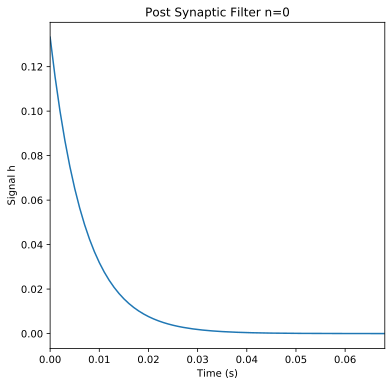

In [23]:
ts, h_t = post_synaptic_filter(7e-3, 0, 1)
   
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(ts, h_t)

b = ts[np.max(np.where(h_t > 1e-3))]
ax.set_xlim(0, min(20, 2 * b))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Signal h")
ax.set_title("Post Synaptic Filter n=0")

Text(0.5, 1.0, 'Post Synaptic Filter n=1')

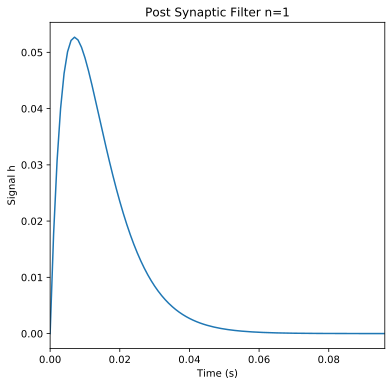

In [24]:
ts, h_t = post_synaptic_filter(7e-3, 1, 1)
   
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(ts, h_t)

b = ts[np.max(np.where(h_t > 1e-3))]
ax.set_xlim(0, min(20, 2 * b))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Signal h")
ax.set_title("Post Synaptic Filter n=1")

Text(0.5, 1.0, 'Post Synaptic Filter n=2')

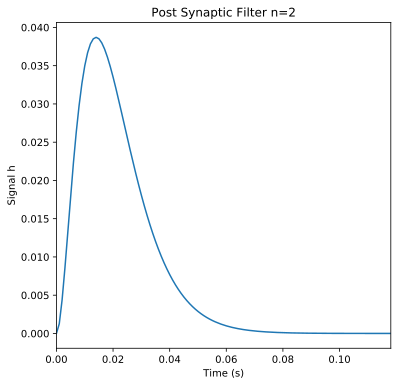

In [25]:
ts, h_t = post_synaptic_filter(7e-3, 2, 1)
   
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(ts, h_t)

b = ts[np.max(np.where(h_t > 1e-3))]
ax.set_xlim(0, min(20, 2 * b))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Signal h")
ax.set_title("Post Synaptic Filter n=2")

**b) Discussion.** What two things do you expect increasing $n$ will do to $\hat{x}(t)$?

✍ By increasing n,  more smoothing of values takes place. Since we are trying to filter our spkikes, this is desireable, as it allows us to account for more time points at once. However, as can be seen by the shifting of the peak, a delay is also compounded, essentially causing the spike to take place at a later time than it actually does.

**c) Plotting the filter for different $\tau$.** Plot the normalized $h(t)$ for $\tau=2\,\mathrm{ms}$, $\tau=5\,\mathrm{ms}$, $\tau=10\,\mathrm{ms}$, $\tau=20\,\mathrm{ms}$ with $n = 0$.

Text(0.5, 1.0, 'Post Synaptic Filter tau=2ms')

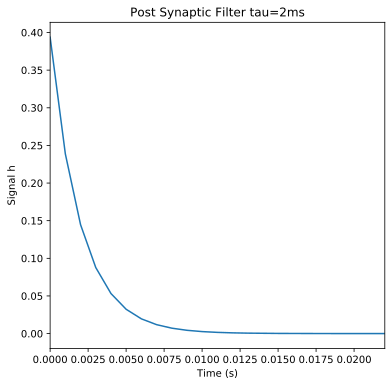

In [26]:
# ✍ 
ts, h_t = post_synaptic_filter(2e-3, 0, 1)
   
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(ts, h_t)

b = ts[np.max(np.where(h_t > 1e-3))]
ax.set_xlim(0, min(20, 2 * b))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Signal h")
ax.set_title("Post Synaptic Filter tau=2ms")

Text(0.5, 1.0, 'Post Synaptic Filter tau=5ms')

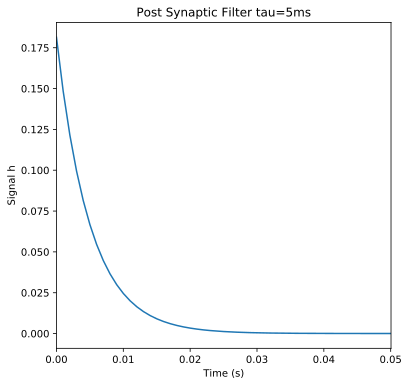

In [27]:
ts, h_t = post_synaptic_filter(5e-3, 0, 1)
   
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(ts, h_t)

b = ts[np.max(np.where(h_t > 1e-3))]
ax.set_xlim(0, min(20, 2 * b))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Signal h")
ax.set_title("Post Synaptic Filter tau=5ms")

Text(0.5, 1.0, 'Post Synaptic Filter tau=10ms')

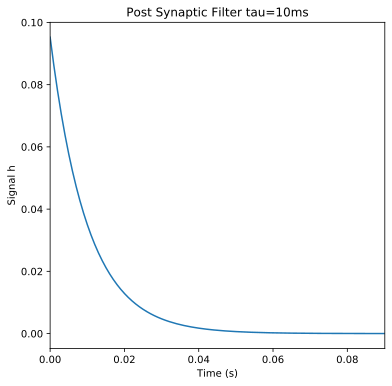

In [28]:
ts, h_t = post_synaptic_filter(10e-3, 0, 1)
   
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(ts, h_t)

b = ts[np.max(np.where(h_t > 1e-3))]
ax.set_xlim(0, min(20, 2 * b))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Signal h")
ax.set_title("Post Synaptic Filter tau=10ms")

Text(0.5, 1.0, 'Post Synaptic Filter tau=20ms')

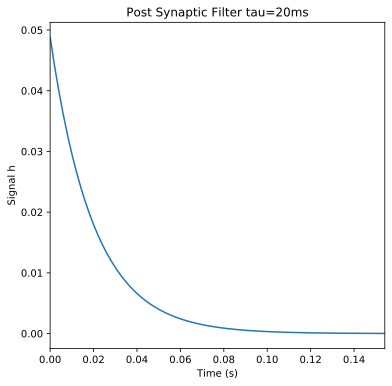

In [29]:
ts, h_t = post_synaptic_filter(20e-3, 0, 1)
   
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(ts, h_t)

b = ts[np.max(np.where(h_t > 1e-3))]
ax.set_xlim(0, min(20, 2 * b))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Signal h")
ax.set_title("Post Synaptic Filter tau=20ms")

**d) Discussion.** What two things do you expect increasing $\tau$ will do to $\hat{x}(t)$?

✍ Increasing tau causes more of the signal to be "widened"/"smoothed", as it is a time constant. However, once again, a delay is added to the peaks.  

**e) Decoding a spike-train using the post-synaptic current filter.** Decode $\hat{x}(t)$ from the spikes generated in question 3c) using an $h(t)$ with $n=0$ and $\tau=7\,\mathrm{ms}$. Do this by generating the spikes, filtering them with $h(t)$, and using that as your activity matrix $A$ to compute your decoders. Plot the time and frequency plots for this $h(t)$. Plot the $x(t)$ signal, the spikes, and the decoded $\hat{x}(t)$ value.

Text(0.5, 1.0, 'Post Synaptic Filter for two neurons, x(t) with limit = 5 Hz')

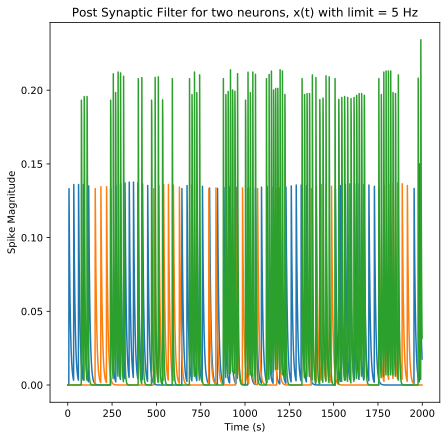

In [30]:
# ✍  
limit = [5]    
_ = random_signal(T=2, dt=1e-3, rms=0.5, limit=limit, 
                      seed=random.seed(18945), signals=1)
fw, X, x, f, a = _.generate_signal() 

ts, v_x_p = spike_neurons(x,1,2)
ts, v_x_n = spike_neurons(x,-1,2)

spike_p = v_x_n.copy() 
spike_p[np.where(~np.logical_or(spike_p==0, spike_p==5))]=0
spike_n = v_x_p.copy() 
spike_n[np.where(~np.logical_or(spike_n==0, spike_n==5))]=0

spike_n_h = np.zeros(len(spike_n))

idx = np.where(spike_n>0)[0] 

for i,s in enumerate(spike_n_h): 
    if i in idx:
        t_in = ts[i]
        spike_n_h_temp = spike_n.copy() 
        for p,t in enumerate(ts):
            if p < i:
                spike_n_h_temp[p] = 0
            else:
                c = np.power(t-t_in,0)*np.exp(np.divide(-(t-t_in),7e-3))
                spike_n_h_temp[p] = c 
        spike_n_h += spike_n_h_temp / np.sum(spike_n_h_temp)

spike_p_h = np.zeros(len(spike_p))

idx = np.where(spike_p>0)[0] 

for i,s in enumerate(spike_p_h): 
    if i in idx:
        t_in = ts[i]
        spike_p_h_temp = spike_p.copy() 
        for p,t in enumerate(ts):
            if p < i:
                spike_p_h_temp[p] = 0
            else:
                c = np.power(t-t_in,0)*np.exp(np.divide(-(t-t_in),7e-3))
                spike_p_h_temp[p] = c 
        spike_p_h += spike_p_h_temp / np.sum(spike_p_h_temp)

ts, h_t = post_synaptic_filter(7e-3, 0, 2)
 
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

SPK = np.concatenate((spike_p_h, spike_n_h), axis=0).reshape(2000,2)

D = np.linalg.lstsq(SPK, x.T, rcond=None)[0] 
x_d = np.dot(SPK,D)  
ax.plot(spike_n_h)
ax.plot(spike_p_h)
ax.plot(x_d)  
ax.set_xlabel("Time (s)")
ax.set_ylabel("Spike Magnitude")
ax.set_title("Post Synaptic Filter for two neurons, x(t) with limit = 5 Hz")

**f) Deocding a spike-train representing a low-frequency signal.** Use the same decoder and $h(t)$ as in part e), but generate a new $x(t)$ with $\mathtt{limit}=2\,\mathrm{Hz}$. Plot the $x(t)$ signal, the spikes, and the decoded $\hat{x}(t)$ value.

Text(0.5, 1.0, 'Post Synaptic Filter for two neurons, x(t) with limit = 2 Hz')

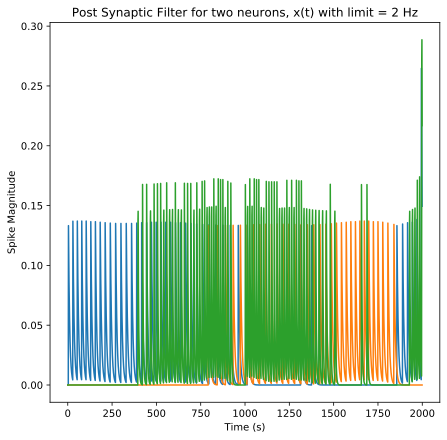

In [31]:
# ✍  
limit = [2]    
_ = random_signal(T=2, dt=1e-3, rms=0.5, limit=limit, 
                      seed=random.seed(18945), signals=1)
fw, X, x, f, a = _.generate_signal() 

ts, v_x_p = spike_neurons(x,1,2)
ts, v_x_n = spike_neurons(x,-1,2)

spike_p = v_x_n.copy() 
spike_p[np.where(~np.logical_or(spike_p==0, spike_p==5))]=0
spike_n = v_x_p.copy() 
spike_n[np.where(~np.logical_or(spike_n==0, spike_n==5))]=0

spike_n_h = np.zeros(len(spike_n))

idx = np.where(spike_n>0)[0] 

for i,s in enumerate(spike_n_h): 
    if i in idx:
        t_in = ts[i]
        spike_n_h_temp = spike_n.copy() 
        for p,t in enumerate(ts):
            if p < i:
                spike_n_h_temp[p] = 0
            else:
                c = np.power(t-t_in,0)*np.exp(np.divide(-(t-t_in),7e-3))
                spike_n_h_temp[p] = c 
        spike_n_h += spike_n_h_temp / np.sum(spike_n_h_temp)

spike_p_h = np.zeros(len(spike_p))

idx = np.where(spike_p>0)[0] 

for i,s in enumerate(spike_p_h): 
    if i in idx:
        t_in = ts[i]
        spike_p_h_temp = spike_p.copy() 
        for p,t in enumerate(ts):
            if p < i:
                spike_p_h_temp[p] = 0
            else:
                c = np.power(t-t_in,0)*np.exp(np.divide(-(t-t_in),7e-3))
                spike_p_h_temp[p] = c 
        spike_p_h += spike_p_h_temp / np.sum(spike_p_h_temp)

ts, h_t = post_synaptic_filter(7e-3, 0, 2)
 
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

SPK = np.concatenate((spike_p_h, spike_n_h), axis=0).reshape(2000,2)

D = np.linalg.lstsq(SPK, x.T, rcond=None)[0] 
x_d = np.dot(SPK,D)  
ax.plot(spike_n_h)
ax.plot(spike_p_h)
ax.plot(x_d)  
ax.set_xlabel("Time (s)")
ax.set_ylabel("Spike Magnitude")
ax.set_title("Post Synaptic Filter for two neurons, x(t) with limit = 2 Hz")

**g) Discussion.** How do the decodings from e) and f) compare? Explain.

✍ Though the outputed plots aren't of the expected form, in theory, the high frequency signal should be more affected by the filtration. This is because the filter takes more time points into account than are actually in the spike. Thus, in a high frequency signal, there's more of a chance of spikes overlapping as they are filtered. In a low frequency signal, there's a lower chance of overlap between filtered peaks.   